# アヤメの分類

## 分類問題の流れ
まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。

この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。

練習のための準備


練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.datasets import load_iris

## 【課題1】練習のために特徴量とカテゴリを選択
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

virgicolorとvirginica
sepal_lengthとpetal_length
《実際の問題では？》

実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [5]:
#データセットをロード
iris = load_iris()
X = iris.data[50:, [0, 2]]
y = iris.target[50:]

In [6]:
X_df = pd.DataFrame(X)
X_df.columns = ['sepal length', 'petal length']
y_df = pd.DataFrame(y)
y_df.columns = ['Species']
df = pd.concat([X_df, y_df], axis=1)

## 【問題2】データの分析
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。

ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

《実際の問題では？》

このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。

今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

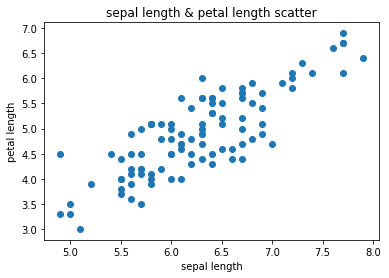

In [7]:
plt.title("sepal length & petal length scatter")
plt.xlabel("sepal length")
plt.ylabel("petal length")
plt.scatter(df.loc[:,"sepal length"], df.loc[:,"petal length"])
plt.show()

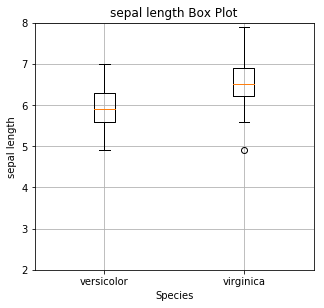

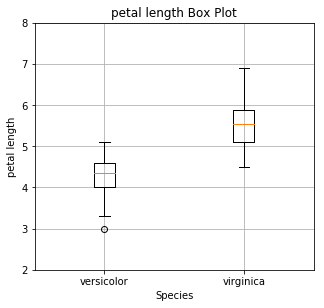

In [8]:
#箱ひげ図

for i in range(2):
    fig = plt.figure(figsize=(5, 10))
    ax = fig.add_subplot(2, 1, i+1)
    ax.boxplot([df.iloc[:50, i],df.iloc[50:, i]])
    ax.set_xticklabels(['versicolor', 'virginica'])
    plt.title("{} Box Plot".format(df.columns[i]))
    plt.xlabel('Species')
    plt.ylabel(df.columns[i])
    plt.ylim([2.0, 8.0])
    plt.grid()
    plt.show()

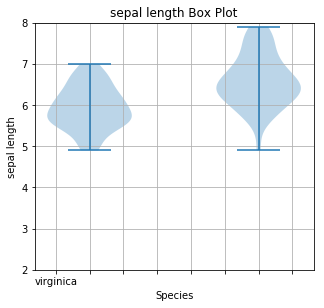

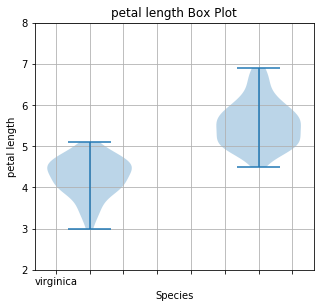

In [9]:
#バイオリン図

for i in range(2):
    fig = plt.figure(figsize=(5, 10))
    ax = fig.add_subplot(2, 1, i+1)
    ax.violinplot([df.iloc[:50, i],df.iloc[50:, i]])
    ax.set_xticklabels(['versicolor', 'virginica'])
    plt.title("{} Box Plot".format(df.columns[i]))
    plt.xlabel('Species')
    plt.ylabel(df.columns[i])
    plt.ylim([2.0, 8.0])
    plt.grid()
    plt.show()

## 【問題3】前処理・訓練用データと検証用データの分割
前処理の一貫として、訓練用（train）データと検証用（validation）データの分割を行います。今回は訓練用データ75%、検証用データ25%として分割してください。

scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。

《注意点》

データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

《分割する理由》

分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練用データ、検証に使うデータが検証用データで、一般的に7対3から8対2程度の割合にします。

In [20]:
df.head()

,sepal length,petal length,Species
0,7.0,4.7,1
1,6.4,4.5,1
2,6.9,4.9,1
3,5.5,4.0,1
4,6.5,4.6,1


In [26]:
# scikit-learnを利用して標準化

from sklearn.model_selection import train_test_split

X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

(75, 2)
(25, 2)


## 【問題4】前処理・標準化
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。

標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

《注意点》

標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証用データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。

《実際の問題での前処理は？》

アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [27]:
#標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。
#検証用データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
std.fit(X_train)
X_train=std.transform(X_train)
X_test=std.transform(X_test)

print(X_test)

[[ 7.91707539e-01 -1.20936285e-01]
 [ 3.81787899e-02  8.46553995e-01]
 [ 9.42413289e-01  2.14825997e-15]
 [ 1.99735354e+00  2.05591684e+00]
 [ 1.39453054e+00  1.33029913e+00]
 [ 7.91707539e-01  1.20936285e+00]
 [-1.01676146e+00 -4.83745140e-01]
 [ 3.81787899e-02  2.14825997e-15]
 [ 3.39590289e-01  1.08842656e+00]
 [ 6.41001789e-01  3.62808855e-01]
 [ 3.81787899e-02  8.46553995e-01]
 [-7.15349959e-01  2.41872570e-01]
 [ 1.88884540e-01  8.46553995e-01]
 [-2.63232710e-01 -2.41872570e-01]
 [-2.07170171e+00 -1.93498056e+00]
 [-1.16746721e+00 -1.33029913e+00]
 [ 3.81787899e-02  2.14825997e-15]
 [ 1.88884540e-01 -7.25617710e-01]
 [-4.13938459e-01  2.41872570e-01]
 [ 4.90296039e-01 -3.62808855e-01]
 [-1.92099596e+00 -1.93498056e+00]
 [ 7.91707539e-01  7.25617710e-01]
 [-1.16746721e+00 -1.08842656e+00]
 [-1.01676146e+00  2.14825997e-15]
 [-8.66055709e-01 -8.46553995e-01]]


## 【問題5】学習と推定
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練用データです。

学習が終わった後、検証用データをpredictメソッドに入力し、推定を行ってください。

パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(y_pred)
print(y_test)

[1 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]


In [36]:
#k=1の場合
knn_1=KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train, y_train)
y_pred_1=knn_1.predict(X_test)
print(y_pred_1)
print(y_test)

[1 2 2 2 2 2 1 2 2 1 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]


In [37]:
#k=3の場合
knn_3=KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)
y_pred_3=knn_3.predict(X_test)
print(y_pred_3)
print(y_test)

[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]


## 【問題6】評価
検証用データの特徴量を入力して得られた推定値と、検証用データの正解値の近さを計算し、学習したモデルを評価します。

2値分類を評価するための指標値には Accuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 があります。それぞれの意味を理解するには、 混同行列（confusion matrix） を見ることになります。

- scikit-learnを使い4種類の指標を計算する
- 混同行列をscikit-learnを使い表示する
- 4種類の指標値の意味について簡単に調査して文章でまとめる

[scikit-learn でクラス分類結果を評価する](https://pythondatascience.plavox.info/scikit-learn/%E5%88%86%E9%A1%9E%E7%B5%90%E6%9E%9C%E3%81%AE%E3%83%A2%E3%83%87%E3%83%AB%E8%A9%95%E4%BE%A1)

**Accuracy（正解率）**

　正解率とは、全てのサンプルのうち正解したサンプルの割合。
 
 $$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$
 
**Precision(適合率)**
 
 　適合率とは、陽性と予測されたサンプルのうち正解したサンプルの割合。FP(偽陽性)と適合率は反比例する。偽陽性を避けたい場合に用いる指標。
  
 $$ Precision = \frac{TP}{TP + FP} $$
  
**Recall(再現率)**

　再現率とは、実際に陽性のサンプルのうち正解したサンプルの割合。FN(偽陰性)と再現率は反比例する。偽陰性を避けたい場合に用いる指標。
 
 $$ Recall = \frac{TP}{TP + FN} $$
 
**F1値(F1-measure)**

　F1値とは、適合率と再現率の調和平均。
 
 $$ F1-measure = \frac{2 * Precision * Recall}{Precision + Recall} = \frac{2 * TP}{2 * TP + FP + FN} $$

In [42]:
#sklearnから各計算fanctionをインポート
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Accuracy(正解率)の算出
print("accuracy: ", accuracy_score(y_test, y_pred))

#Precision（適合率）の算出
print("precision: ", precision_score(y_test, y_pred))
 
#Recall（再現率）の算出
print("recall: ", recall_score(y_test, y_pred))

#F値の算出
print("f1_score: ", f1_score(y_test, y_pred))

#混同行列（confusion matrix）
print("confusion_matrix: \n", confusion_matrix(y_test, y_pred))

accuracy:  0.88
precision:  1.0
recall:  0.7692307692307693
f1_score:  0.8695652173913044
confusion_matrix: 
 [[10  3]
 [ 0 12]]


## 問題7】可視化
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練用データまたは検証用データを与えます。

In [51]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

この例では訓練用データをプロットし、どのように学習したかを見ています。一方で、検証用データをプロットすればどういった特徴量のものが間違って分類されたかを見ることができます。

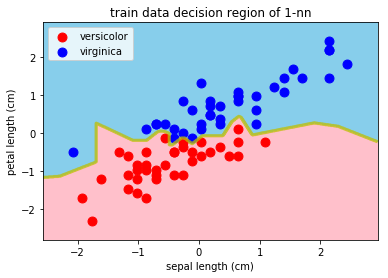

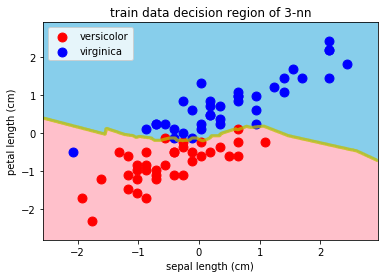

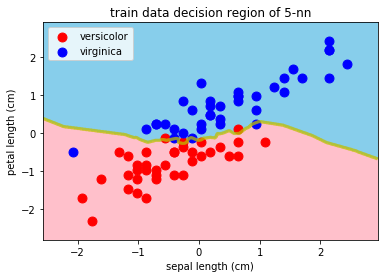

In [53]:
#訓練用データ
decision_region(X_train, y_train, knn_1, title='train data decision region of 1-nn', xlabel='sepal length (cm)', ylabel='petal length (cm)')
decision_region(X_train, y_train, knn_3, title='train data decision region of 3-nn', xlabel='sepal length (cm)', ylabel='petal length (cm)')
decision_region(X_train, y_train, knn, title='train data decision region of 5-nn', xlabel='sepal length (cm)', ylabel='petal length (cm)')

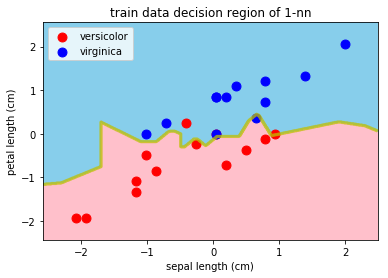

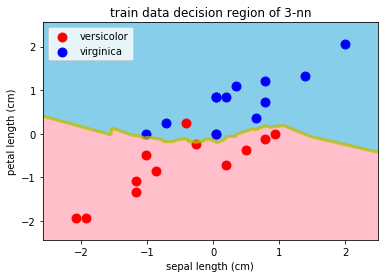

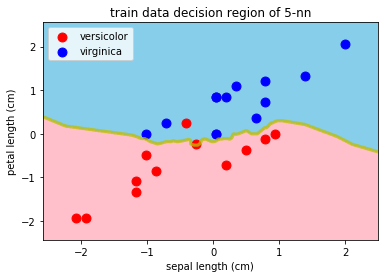

In [54]:
#検証データ
decision_region(X_test, y_test, knn_1, title='train data decision region of 1-nn', xlabel='sepal length (cm)', ylabel='petal length (cm)')
decision_region(X_test, y_test, knn_3, title='train data decision region of 3-nn', xlabel='sepal length (cm)', ylabel='petal length (cm)')
decision_region(X_test, y_test, knn, title='train data decision region of 5-nn', xlabel='sepal length (cm)', ylabel='petal length (cm)')

手法の改善
実際の問題では指標値や可視化を元に手法を改善していきますが、この課題では扱いません。

各手法の比較
他の手法も基本的な流れは同様です。他の手法でも学習から可視化までを行っていきます。

## 【問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。

《実際の問題では？》

ハイパーパラメータの調整は パラメータチューニング と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy:  0.92
precision:  1.0
recall:  0.8461538461538461
f1_score:  0.9166666666666666
confusion matrix:
 [[11  2]
 [ 0 12]]


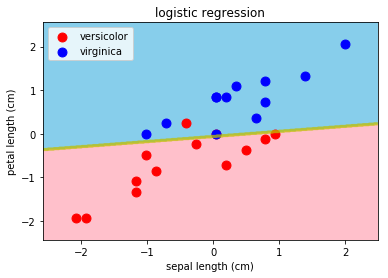

In [57]:
#ロジスティック回帰
from sklearn.linear_model import LogisticRegression
Ir=LogisticRegression()
Ir.fit(X_train, y_train)
y_pred=Ir.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
con_mat=confusion_matrix(y_test, y_pred)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1_score: ', f1) 
print('confusion matrix:\n', con_mat)

#グラフ描写
decision_region(X_test, y_test, Ir, title='logistic regression', xlabel='sepal length (cm)', ylabel='petal length (cm)')


SVM
accuracy:  0.92
precision:  1.0
recall:  0.8461538461538461
f1_score:  0.9166666666666666
confusion matrix:
 [[11  2]
 [ 0 12]]


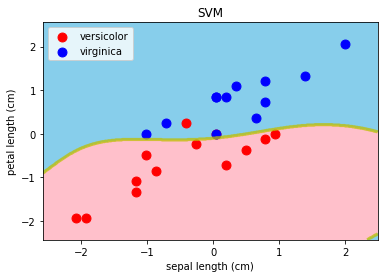

In [59]:
#SVM
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train, y_train)
y_pred=svc.predict(X_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
con_mat=confusion_matrix(y_test, y_pred)
print('SVM')
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1_score: ', f1)
print('confusion matrix:\n', con_mat)

#可視化
decision_region(X_test, y_test, svc, title='SVM', xlabel='sepal length (cm)', ylabel='petal length (cm)')


decision tree
accuracy:  0.88
precision:  1.0
recall:  0.7692307692307693
f1_score:  0.8695652173913044
confusion matrix:
 [[10  3]
 [ 0 12]]


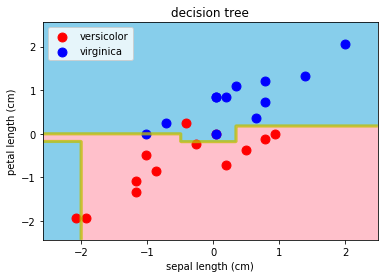

In [60]:
#決定木
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
con_mat=confusion_matrix(y_test, y_pred)
print('decision tree')
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1_score: ', f1)
print('confusion matrix:\n', con_mat)

#可視化
decision_region(X_test, y_test, tree, title='decision tree', xlabel='sepal length (cm)', ylabel='petal length (cm)')


/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


random forest
accuracy:  0.88
precision:  1.0
recall:  0.7692307692307693
f1_score:  0.8695652173913044
confusion matrix:
 [[10  3]
 [ 0 12]]


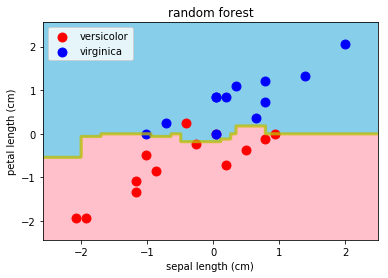

In [61]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
con_mat=confusion_matrix(y_test, y_pred)
print('random forest')
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1_score: ', f1)
print('confusion matrix:\n', con_mat)

#可視化
decision_region(X_test, y_test, rf, title='random forest', xlabel='sepal length (cm)', ylabel='petal length (cm)')

## 【問題9】（アドバンス課題）標準化の有無の比較
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

## 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。

《多値になることでの変更点》

指標値Precision（適合率）、Recall（再現率）、F値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。

決定領域を可視化する前述の関数は適切に書き換える必要があります。以下が出力例です。

ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは自動的に判断して処理が行われるため変更は必要ありません。



[機械学習-アヤメの分類 (プログラム)](https://newtechnologylifestyle.net/tensorflow-keras%E3%81%A7%E3%81%AE%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92%E3%80%80-%E3%82%A2%E3%83%A4%E3%83%A1%E3%81%AE%E5%88%86%E9%A1%9E/)